# Predizione del Successo di Progetti Kickstarter

## Contesto e obiettivo

Kickstarter è una delle principali piattaforme di crowdfunding, dove creatori di progetti possono raccogliere fondi per realizzare idee innovative. L’interesse verso il crowdfunding è nato dopo aver scoperto il caso di Star Citizen, uno dei progetti più finanziati nella storia di Kickstarter (e ancora oggi in fase di sviluppo). Tuttavia, non tutti i progetti raggiungono il proprio obiettivo di finanziamento.  
L’obiettivo di questo progetto è costruire un modello predittivo che, dati i parametri di un nuovo progetto, stimi se la campagna avrà successo (verrà finanziata) o meno.  
Alla fine, sarà realizzata una web app che permetterà di inserire le caratteristiche di una proposta e ricevere una previsione, con eventuali suggerimenti di modifica.

## Fonte e struttura del dataset

Il dataset utilizzato è [Kickstarter Projects](https://www.kaggle.com/datasets/kemical/kickstarter-projects), scaricato da Kaggle.  
`ks-projects-201801.csv` contiene informazioni su oltre 300.000 progetti lanciati su Kickstarter fino al 2018.

### Variabili principali del dataset

- `ID`: identificatore univoco del progetto
- `name`: nome del progetto
- `category`: categoria del progetto
- `main_category`: macro-categoria
- `currency`: valuta utilizzata
- `deadline`: data di scadenza della campagna
- `goal`: obiettivo di raccolta fondi
- `launched`: data di lancio
- `pledged`: fondi raccolti
- `state`: stato finale del progetto (success, failed, canceled, ecc.)
- `backers`: numero di sostenitori
- `country`: paese di origine
- `usd_pledged`: conversione in dollari americani della colonna pledged (conversione effettuata da Kickstarter)
- `usd_pledged_real`: conversione in dollari americani della colonna pledged (conversione effettuata tramite API Fixer.io)
- `usd_goal_real`: conversione in dollari americani della colonna goal (conversione effettuata tramite API Fixer.io)

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

file_path = "data/ks-projects-201801.csv"
kickstarter_data = pd.read_csv(file_path)
kickstarter_data.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


## Scrematura e rielaborazione delle variabili

In questa sezione vengono selezionate e rielaborate le variabili del dataset da utilizzare per l’addestramento del modello predittivo.  
L’obiettivo è mantenere solo le informazioni disponibili prima del lancio della campagna, eliminando variabili non informative (come identificativi) o non utilizzabili in fase predittiva (come i risultati effettivi della raccolta fondi).

Inoltre, vengono create nuove feature derivate dalle date (`duration_days`, `launch_month`, `launch_year`, `deadline_month`, `deadline_year`) per fornire al modello informazioni aggiuntive sulla tempistica della campagna.  
La variabile target sarà `state`, che indica l’esito della campagna.

Le variabili selezionate saranno quindi utilizzate per la fase di preprocessing e per l’addestramento dei modelli.

In [16]:
kickstarter_data['launched'] = pd.to_datetime(kickstarter_data['launched'])
kickstarter_data['deadline'] = pd.to_datetime(kickstarter_data['deadline'])
kickstarter_data['duration_days'] = (kickstarter_data['deadline'] - kickstarter_data['launched']).dt.days

kickstarter_data['launch_month'] = kickstarter_data['launched'].dt.month
kickstarter_data['launch_year'] = kickstarter_data['launched'].dt.year

kickstarter_data['deadline_month'] = kickstarter_data['deadline'].dt.month
kickstarter_data['deadline_year'] = kickstarter_data['deadline'].dt.year

features = [
    'name', 'category', 'main_category', 'currency', 'country', 'goal', 'usd_goal_real',
    'duration_days', 'launch_month', 'launch_year', 'deadline_month', 'deadline_year'
]

target = 'state'

feature_set = kickstarter_data[features]
target_set = kickstarter_data[target]

feature_set.head()

,name,category,main_category,currency,country,goal,usd_goal_real,duration_days,launch_month,launch_year,deadline_month,deadline_year
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,GB,1000.0,1533.95,58,8,2015,10,2015
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,US,30000.0,30000.00,59,9,2017,11,2017
2,Where is Hank?,Narrative Film,Film & Video,USD,US,45000.0,45000.00,44,1,2013,2,2013
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,US,5000.0,5000.00,29,3,2012,4,2012
4,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,US,19500.0,19500.00,55,7,2015,8,2015


## Analisi esplorativa del dataset

In questa sezione vengono analizzate le principali caratteristiche statistiche delle variabili, la distribuzione della variabile target e delle feature numeriche, e le correlazioni tra variabili. I risultati guideranno eventuali scelte di filtraggio o trasformazione dei dati.

In [ ]:
feature_set.describe()

,goal,usd_goal_real,duration_days,launch_month,launch_year,deadline_month,deadline_year
count,3.786610e+05,3.786610e+05,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000
mean,4.908079e+04,4.545440e+04,33.481122,6.461550,2014.247829,6.720726,2014.320698
std,1.183391e+06,1.152950e+06,65.909172,3.330133,1.933293,3.342550,1.924450
min,1.000000e-02,1.000000e-02,0.000000,1.000000,1970.000000,1.000000,2009.000000
25%,2.000000e+03,2.000000e+03,29.000000,4.000000,2013.000000,4.000000,2013.000000
50%,5.200000e+03,5.500000e+03,29.000000,7.000000,2014.000000,7.000000,2015.000000
75%,1.600000e+04,1.550000e+04,36.000000,9.000000,2016.000000,10.000000,2016.000000
max,1.000000e+08,1.663614e+08,16738.000000,12.000000,2018.000000,12.000000,2018.000000


Le statistiche descrittive mostrano media, quartili, minimi, massimi e possibili outlier nelle variabili numeriche.

In [ ]:
feature_set.describe(include='object')

,name,category,main_category,currency,country
count,378657,378661,378661,378661,378661
unique,375764,159,15,14,23
top,New EP/Music Development,Product Design,Film & Video,USD,US
freq,41,22314,63585,295365,292627


Le variabili categoriche presentano una buona varietà di valori distinti.

In [ ]:
feature_set.nunique()

name              375764
category             159
main_category         15
currency              14
country               23
goal                8353
usd_goal_real      50339
duration_days         99
launch_month          12
launch_year           11
deadline_month        12
deadline_year         10
dtype: int64

Il conteggio dei valori distinti aiuta a identificare feature con bassa variabilità o potenzialmente inutili.

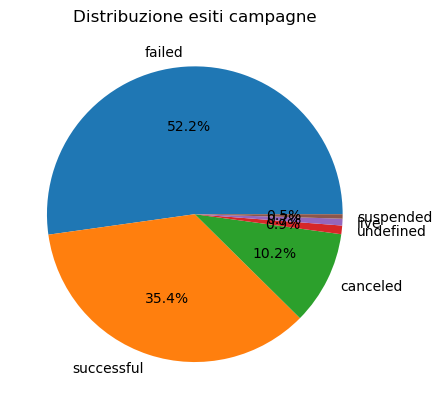

In [23]:
# Distribuzione della variabile target (state)
target_set.value_counts(normalize=True).plot.pie(autopct='%1.1f%%', ylabel='', title='Distribuzione esiti campagne')
plt.show()

La distribuzione della variabile target evidenzia uno sbilanciamento: la maggior parte delle campagne non ha successo.

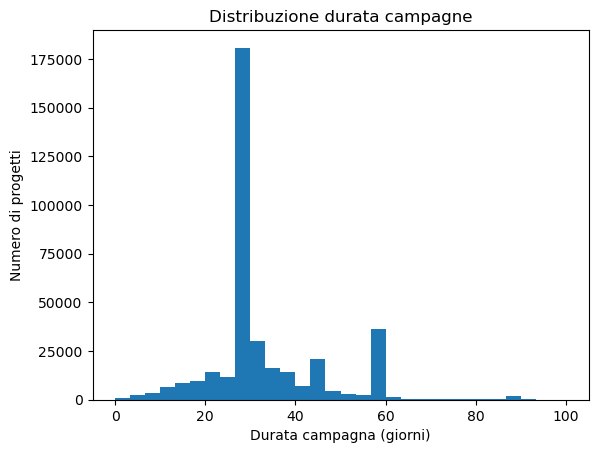

In [31]:
# Istogramma della durata delle campagne
feature_set['duration_days'].plot.hist(bins=30, range=(0, 100))
plt.xlabel('Durata campagna (giorni)')
plt.ylabel('Numero di progetti')
plt.title('Distribuzione durata campagne')
plt.show()

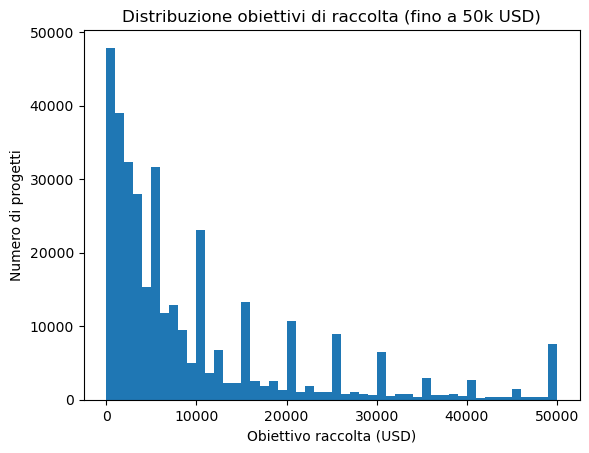

In [26]:
# Istogramma degli obiettivi di raccolta (usd_goal_real)
feature_set['usd_goal_real'].plot.hist(bins=50, range=(0, 50000))
plt.xlabel('Obiettivo raccolta (USD)')
plt.ylabel('Numero di progetti')
plt.title('Distribuzione obiettivi di raccolta (fino a 50k USD)')
plt.show()

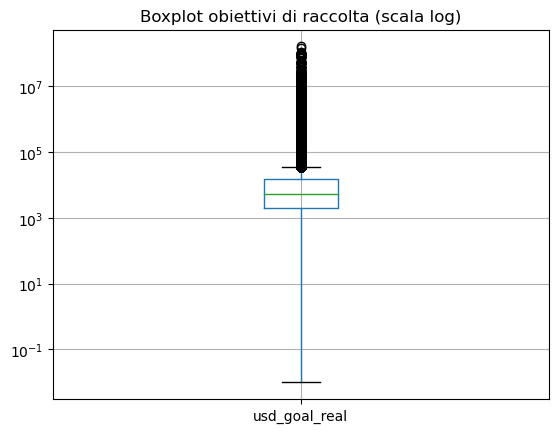

In [27]:
# Boxplot per individuare outlier negli obiettivi di raccolta
feature_set.boxplot(column='usd_goal_real')
plt.yscale('log')
plt.title('Boxplot obiettivi di raccolta (scala log)')
plt.show()

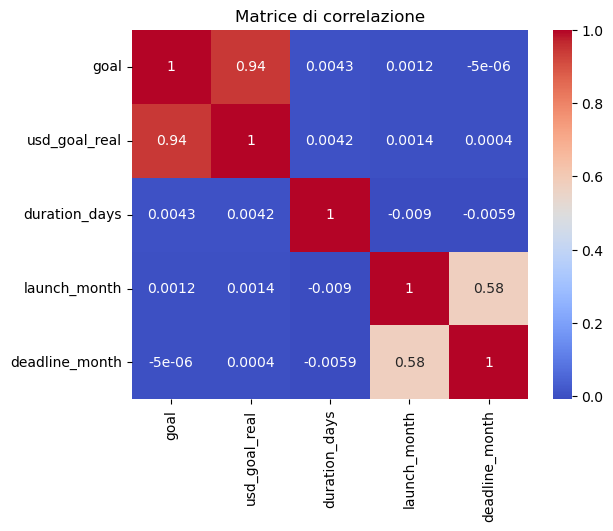

In [28]:
# Matrice di correlazione tra variabili numeriche
import seaborn as sns
corr = feature_set[['goal', 'usd_goal_real', 'duration_days', 'launch_month', 'deadline_month']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Matrice di correlazione')
plt.show()

**Conclusioni:**  
- La maggior parte dei progetti ha una durata tra 30 e 60 giorni e un obiettivo di raccolta inferiore a 50.000 USD, ma sono presenti outlier.
- La variabile target è sbilanciata: la maggior parte delle campagne fallisce.
- Le variabili categoriche hanno buona varietà, ma alcune potrebbero essere raggruppate o filtrate.